# BTC PRICE ESTIMATING ML MODEL
## Description
This is a machine learning model that estimates the bitcoin closing price, according to the dates, closing price, and volumes.
The model architechture is a feed forward model
- Loss function: MSELoss
- Optimizer: Adam
- Num of hidden layers 3
- input layer size = 8
- output layer size = 1
- Activation function: ReLU
- output activation = None

## Model Evaluation
- This model is evaluated using R2Score

## Dataset
- Dataset is sourced from kaggle: https://www.kaggle.com/datasets/aski1140/bitcoin-prices-minutes-2020-2024
- For this model we used the prices from 01.01.2020-31.12.2020

In [46]:
# Importing necessary libraries/modules/functions
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics

In [47]:
# Defining  on which device to run the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [59]:
# Data preprocessing (cleaning, changing datatypes, adding variables, etc)
data = pd.read_csv("../datasets/Binance_BTCUSDT_2020_minute.csv")
data["date"] = pd.to_datetime(data["date"], format='%Y-%m-%d %H:%M:%S')

data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["hour"] = data["date"].dt.hour
data["minute"] = data["date"].dt.minute
data.drop(columns=['date'])

# Reversing the data so that the oldest is the first row and the newest is the last row
data = data.iloc[::-1]

In [49]:
# Extract the features and labels
features = data.iloc[:, [10,11,12,13,14,3,7,8]]
labels = data.iloc[:, 6]
# Scaling the data and reshaping them into proper forms
scaler = StandardScaler()
features = scaler.fit_transform(features.to_numpy("float32"))
labels = scaler.fit_transform(labels.to_numpy("float32").reshape(-1,1))

# Turning them into tensors
features = torch.tensor(features)
labels = torch.tensor(labels).reshape(-1,1)

In [50]:
# Defining hyperparameters
epochs = 2
batchsize = 100
inputsz = features.shape[1]
h1size = 16
h2size = 16
h3size = 16
outsz = labels.shape[1]
learning_rate = 0.0001

In [51]:
# Creating custom dataset class that inherits Dataset module
class BTCdataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    # Returns the length of the dataset (the num of rows/samples)
    def __len__(self):
        return len(self.labels)

    # Returns the feature row, and the label at the index location
    def __getitem__(self, idx):
        input = self.features[idx]
        label = self.labels[idx]
        return input, label

In [52]:
# Splitting our data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, train_size=0.8)

# Initializing our custom dataset class, which is then used to initialize DataLoader class
# Dataloader class is what is used to train and test our model
traindb = BTCdataset(xtrain,ytrain)
testdb = BTCdataset(xtest, ytest)

# Init. dataloader with batchsize and shuffle, etc specifications
trainloader = DataLoader(traindb, batch_size=batchsize, shuffle=False)
testloader = DataLoader(testdb, batch_size=batchsize, shuffle=False)

In [53]:
# Creating our model architecture
class BTCpredictor(nn.Module):
    def __init__(self, input_sz, hid1, hid2, hid3, outsize, activation=nn.ReLU()):
        super(BTCpredictor, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_sz, hid1),
            activation,
            nn.Linear(hid1, hid2),
            activation,
            nn.Linear(hid2, hid3),
            activation,
            nn.Linear(hid3, outsize)
        )
    def forward(self, x):
        output = self.sequential(x)
        return output

In [54]:
# Initializing our model, loss function, activation function
model = BTCpredictor(inputsz, h1size, h2size, h3size, outsz).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [55]:
# Training the model
model.train()
for epoch in range(epochs):
    for inputs, label in trainloader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        label = label.to(device)

        output = model(inputs)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        print(f"MSEloss: {loss}")

MSEloss: 1.3021787405014038
MSEloss: 0.9619503021240234
MSEloss: 0.9141448736190796
MSEloss: 0.7368211150169373
MSEloss: 1.1695116758346558
MSEloss: 0.8993408679962158
MSEloss: 0.75697261095047
MSEloss: 1.2276016473770142
MSEloss: 0.8842621445655823
MSEloss: 0.774028480052948
MSEloss: 1.192637324333191
MSEloss: 0.7012302279472351
MSEloss: 1.0364742279052734
MSEloss: 0.9058365225791931
MSEloss: 1.0125484466552734
MSEloss: 1.1194838285446167
MSEloss: 0.8876547813415527
MSEloss: 1.6189286708831787
MSEloss: 0.8892644047737122
MSEloss: 0.956448495388031
MSEloss: 1.0127038955688477
MSEloss: 0.8530234098434448
MSEloss: 0.9022140502929688
MSEloss: 0.891922652721405
MSEloss: 0.9557111859321594
MSEloss: 1.3587150573730469
MSEloss: 0.9179986119270325
MSEloss: 1.0692086219787598
MSEloss: 1.1173169612884521
MSEloss: 0.912850022315979
MSEloss: 1.1436823606491089
MSEloss: 1.0175451040267944
MSEloss: 1.0911234617233276
MSEloss: 0.7116854786872864
MSEloss: 0.9474810361862183
MSEloss: 0.9056553244590759

In [56]:
# Evaluating the model
model.eval()

# Initializing the metric
R2metric = torchmetrics.R2Score().to(device)

predicted = []
actuals = []
x_values = []

with torch.no_grad():
    for input, label in testloader:
        input = input.to(device)
        label = label.to(device)

        out = model(input)
        predicted.extend(out.cpu().numpy())
        actuals.extend(label.cpu().numpy())
        x_values.extend(input[:,0].cpu().numpy())
        # Update R2 metric with predictions and true labels
        R2metric.update(out, label)

R2score = R2metric.compute()
print(f"R2 Score: {R2score:.4f}")

R2metric.reset()

R2 Score: 0.9996


In [57]:
# Checking a single sample test
with torch.no_grad():
    for input, label in testloader:
        input = input.to(device)
        label = label.to(device)
        out = model(input)
        print(f"prediction: {out[0]}\n actual: {label[0]}")
        if True: break
         

prediction: tensor([-0.4552], device='cuda:0')
 actual: tensor([-0.4465], device='cuda:0')


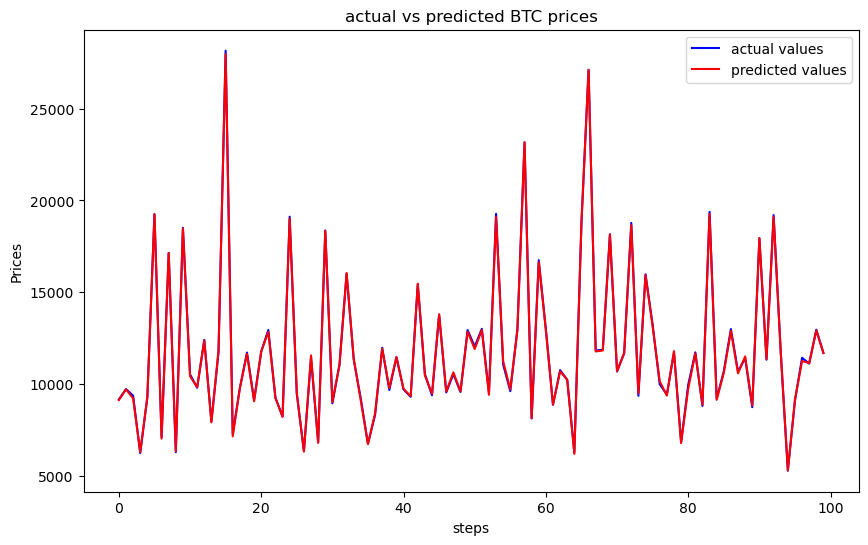

In [58]:
# Plotting the testing results:
predicted = scaler.inverse_transform(predicted)
actuals = scaler.inverse_transform(actuals)
x_values = scaler.inverse_transform(np.asarray(x_values).reshape(-1,1))

plt.figure(figsize=(10, 6))
plt.plot(actuals[:100], label="actual values", color="blue")
plt.plot(predicted[:100], label = "predicted values", color="red")
plt.xlabel("steps")
plt.ylabel("Prices")
plt.title("actual vs predicted BTC prices")
plt.legend()